## Nome: Gustavo Queiroz Ribeiro
## RM: 361485

Trabalho avaliativo da materia: *Distributed Data Processing & Storage* no MBA de Engenharia de Dados da FIAP.

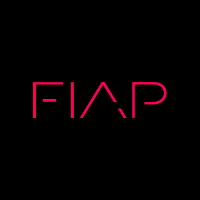

OBS: Executar na ordem correta.

### Importações e ETL

In [109]:
from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder.appName("Spark-trabalho-fiap").getOrCreate()
spark

In [110]:
url = "https://raw.githubusercontent.com/queirozene/fiap-public-data/refs/heads/main/csv/results%20(1).csv"

data = pd.read_csv(url)
df = spark.createDataFrame(data)

df.show(3)

+----------+-------------+-------------+--------------+--------------+--------------+--------+--------------+-----------+
|      date|home_teamName|away_teamName|home_scoreHome|away_scoreAway|tournamentName|cityCity|countryCountry|neutralTRUE|
+----------+-------------+-------------+--------------+--------------+--------------+--------+--------------+-----------+
|1872-11-30|     Scotland|      England|             0|             0|      Friendly| Glasgow|      Scotland|      false|
|1873-03-08|      England|     Scotland|             4|             2|      Friendly|  London|       England|      false|
|1874-03-07|     Scotland|      England|             2|             1|      Friendly| Glasgow|      Scotland|      false|
+----------+-------------+-------------+--------------+--------------+--------------+--------+--------------+-----------+
only showing top 3 rows



In [111]:
df = df.drop("neutralTRUE")

In [112]:
df = (
    df.withColumnRenamed("date", "data_da_partida")
    .withColumnRenamed("home_teamName", "time_mandante")
    .withColumnRenamed("away_teamName", "time_visitante")
    .withColumnRenamed("home_scoreHome", "placar_mandante")
    .withColumnRenamed("away_scoreAway", "placar_visitante")
    .withColumnRenamed("tournamentName", "torneio")
    .withColumnRenamed("cityCity", "cidade")
    .withColumnRenamed("countryCountry", "pais")
)

### 1. Quantos registros existem na base?

In [113]:
# python (spark)

qtd_registros = df.count()

print(f"Na base existem {qtd_registros} registros.")

Na base existem 40839 registros.


In [114]:
# sql

df.createOrReplaceTempView("jogos")

spark.sql('''
          SELECT
            COUNT(*) as `Quantidade de Registros`
          FROM jogos
          ''').show(5, truncate=False)

+-----------------------+
|Quantidade de Registros|
+-----------------------+
|40839                  |
+-----------------------+



### 2. Quantas equipes únicas mandantes existem na base?

In [115]:
# python (spark)

times_mandantes_unicos = df.select("time_mandante").distinct().count()

print(f"Na base existem {times_mandantes_unicos} times mandantes únicos.")

Na base existem 309 times mandantes únicos.


In [116]:
# sql

df.createOrReplaceTempView("jogos")

spark.sql('''
          SELECT
            COUNT(DISTINCT time_mandante) as `Quantidade de Times Mandantes`
          FROM jogos
          ''').show(truncate=False)

+-----------------------------+
|Quantidade de Times Mandantes|
+-----------------------------+
|309                          |
+-----------------------------+



### 3. Quantas vezes as equipes mandantes saíram vitoriosas?

In [117]:
# python (Spark)

mandantes_vitoria = df.filter(df.placar_mandante > df.placar_visitante).count()

print(f"Na base existem {mandantes_vitoria} partidas onde o time mandante venceu.")

Na base existem 19864 partidas onde o time mandante venceu.


In [118]:
# sql

spark.sql('''
          SELECT
            COUNT(time_mandante) as `Quantidade de vitorias time mandante`
          FROM jogos
          WHERE placar_mandante > placar_visitante
          ''').show(truncate=False)

+------------------------------------+
|Quantidade de vitorias time mandante|
+------------------------------------+
|19864                               |
+------------------------------------+



### 4. Quantas vezes as equipes visitantes saíram vitoriosas?

In [119]:
# python (Spark)

visitante_vitoria = df.filter(df.placar_visitante > df.placar_mandante).count()

print(f"Na base existem {visitante_vitoria} partidas onde o time visitante venceu.")

Na base existem 11544 partidas onde o time visitante venceu.


In [120]:
# sql

spark.sql('''
          SELECT
            COUNT(time_visitante) as `Quantidade de vitorias time visitante`
          FROM jogos
          WHERE placar_mandante < placar_visitante
          ''').show(truncate=False)

+-------------------------------------+
|Quantidade de vitorias time visitante|
+-------------------------------------+
|11544                                |
+-------------------------------------+



### 5. Quantas partidas resultaram em empate?

In [121]:
# python (Spark)

empates = df.filter(df.placar_visitante == df.placar_mandante).count()

print(f"Na base existem {empates} partidas onde o resultado final foi empate.")

Na base existem 9431 partidas onde o resultado final foi empate.


In [122]:
# sql

spark.sql('''
          SELECT
            COUNT(*) as `Quantidade de partidas empatadas`
          FROM jogos
          WHERE placar_mandante = placar_visitante
          ''').show(truncate=False)

+--------------------------------+
|Quantidade de partidas empatadas|
+--------------------------------+
|9431                            |
+--------------------------------+



### 6. Quantas partidas foram realizadas em cada país?

In [123]:
# python (Spark)

paises_distintos = df.select(df.pais).distinct().count()
print(f"Existem {paises_distintos} paises que sediaram partidas, segue o nome do pais e a quantidade de jogos realizados no mesmo:")

df.groupBy(df.pais).count().orderBy("count", ascending=False).show(266, truncate=False)

Existem 266 paises que sediaram partidas, segue o nome do pais e a quantidade de jogos realizados no mesmo:
+--------------------------------+-----+
|pais                            |count|
+--------------------------------+-----+
|United States                   |1144 |
|France                          |801  |
|England                         |687  |
|Malaysia                        |644  |
|Sweden                          |637  |
|Germany                         |581  |
|Brazil                          |529  |
|Spain                           |517  |
|Thailand                        |483  |
|Italy                           |480  |
|Switzerland                     |477  |
|Austria                         |475  |
|United Arab Emirates            |472  |
|South Africa                    |470  |
|Qatar                           |467  |
|South Korea                     |453  |
|Argentina                       |449  |
|Hungary                         |431  |
|Chile                         

In [124]:
# sql

spark.sql('''
          SELECT
            pais,
            count(*) AS `quantidade de jogos`
          FROM jogos
          GROUP BY pais
          ORDER BY `quantidade de jogos` DESC
          ''').show(266)

+--------------------+-------------------+
|                pais|quantidade de jogos|
+--------------------+-------------------+
|       United States|               1144|
|              France|                801|
|             England|                687|
|            Malaysia|                644|
|              Sweden|                637|
|             Germany|                581|
|              Brazil|                529|
|               Spain|                517|
|            Thailand|                483|
|               Italy|                480|
|         Switzerland|                477|
|             Austria|                475|
|United Arab Emirates|                472|
|        South Africa|                470|
|               Qatar|                467|
|         South Korea|                453|
|           Argentina|                449|
|             Hungary|                431|
|               Chile|                405|
|             Belgium|                396|
|          

### 7. Qual país teve mais partidas?


In [125]:
# python (Spark)

df_paises_partidas = df.groupBy(df.pais).count().orderBy("count", ascending=False).limit(1)

df_paises_partidas.show(truncate=False)

top_pais = df_paises_partidas.collect()[0]

pais = top_pais["pais"]
partidas = top_pais["count"]

print(f"O pais com mais partidas foi o {pais} com um total de {partidas} partidas.")

+-------------+-----+
|pais         |count|
+-------------+-----+
|United States|1144 |
+-------------+-----+

O pais com mais partidas foi o United States com um total de 1144 partidas.


In [126]:
# sql

spark.sql('''
          SELECT
            pais AS `pais com mais jogos`,
            count(*) AS `quantidade de jogos`
          FROM jogos
          GROUP BY pais
          ORDER BY `quantidade de jogos` DESC
          LIMIT 1
          ''').show()

+-------------------+-------------------+
|pais com mais jogos|quantidade de jogos|
+-------------------+-------------------+
|      United States|               1144|
+-------------------+-------------------+



### 8. Qual a partida com maior número de gols?

In [127]:
# python (Spark)

# verificação dos dados para ver se não tem mais de uma partida com o maior números de gols iguais

df_resultados = df.withColumns({'soma_placares': df.placar_mandante + df.placar_visitante})

df_resultados.orderBy("soma_placares", ascending=False).show(10)


+---------------+--------------+----------------+---------------+----------------+--------------------+-------------+----------------+-------------+
|data_da_partida| time_mandante|  time_visitante|placar_mandante|placar_visitante|             torneio|       cidade|            pais|soma_placares|
+---------------+--------------+----------------+---------------+----------------+--------------------+-------------+----------------+-------------+
|     2001-04-11|     Australia|  American Samoa|             31|               0|FIFA World Cup qu...|Coffs Harbour|       Australia|           31|
|     1971-09-13|        Tahiti|    Cook Islands|             30|               0| South Pacific Games|      Papeete|French Polynesia|           30|
|     1979-08-30|          Fiji|        Kiribati|             24|               0| South Pacific Games|      Nausori|            Fiji|           24|
|     2001-04-09|     Australia|           Tonga|             22|               0|FIFA World Cup qu...|Cof

In [128]:
# python (Spark)

df_partida_maior_placar = df_resultados.orderBy("soma_placares", ascending=False).limit(1)

df_partida_maior_placar.show(truncate=False)

dados_partida = df_partida_maior_placar.collect()[0]

data = dados_partida["data_da_partida"]
mandante = dados_partida["time_mandante"]
visitante = dados_partida["time_visitante"]
placar_mandante = dados_partida["placar_mandante"]
placar_visitante = dados_partida["placar_visitante"]
soma_resultado = dados_partida["soma_placares"]

print(f"A partida com o maior número de gols foi realizada na data de {data}, \
entre as seleções da {mandante} x {visitante} com o resultado de {placar_mandante} x {placar_visitante} para a seleção da {mandante}. \
Com o total de {soma_resultado} gols.")

+---------------+-------------+--------------+---------------+----------------+----------------------------+-------------+---------+-------------+
|data_da_partida|time_mandante|time_visitante|placar_mandante|placar_visitante|torneio                     |cidade       |pais     |soma_placares|
+---------------+-------------+--------------+---------------+----------------+----------------------------+-------------+---------+-------------+
|2001-04-11     |Australia    |American Samoa|31             |0               |FIFA World Cup qualification|Coffs Harbour|Australia|31           |
+---------------+-------------+--------------+---------------+----------------+----------------------------+-------------+---------+-------------+

A partida com o maior número de gols foi realizada na data de 2001-04-11, entre as seleções da Australia x American Samoa com o resultado de 31 x 0 para a seleção da Australia. Com o total de 31 gols.


In [129]:
# sql

spark.sql('''
          SELECT
            data_da_partida,
            time_mandante,
            time_visitante,
            placar_mandante,
            placar_visitante,
            sum(placar_mandante + placar_visitante) as soma_placares
          FROM jogos
          GROUP BY data_da_partida, time_mandante, time_visitante, placar_mandante, placar_visitante
          ORDER BY soma_placares DESC
          LIMIT 1
          ''').show()

+---------------+-------------+--------------+---------------+----------------+-------------+
|data_da_partida|time_mandante|time_visitante|placar_mandante|placar_visitante|soma_placares|
+---------------+-------------+--------------+---------------+----------------+-------------+
|     2001-04-11|    Australia|American Samoa|             31|               0|           31|
+---------------+-------------+--------------+---------------+----------------+-------------+



### 9. Qual a maior goleada?

Essa pergunta poderia ser respondida utilizando o resultado da questão 8.

Pois a partida com maior número de gols coincidentemente foi a maior goleada utilizando o parametro de "goleada" no futebol = (saldo de: gols marcados - gols sofridos).

Porém, utilizarei uma mecanica de criar esse dado de saldo de gols por partida para encontrar a maior diferença e mudar o método de responder a questão.

In [130]:
# python (Spark)

df_home_win = df.select('*').where(df.placar_mandante > df.placar_visitante)

df_away_win = df.select('*').where(df.placar_visitante > df.placar_mandante)

df_home_win = df_home_win.withColumns({'saldo_gols': df_home_win.placar_mandante - df_home_win.placar_visitante}).orderBy('saldo_gols', ascending=False)
df_away_win = df_away_win.withColumns({'saldo_gols': df_away_win.placar_visitante - df_away_win.placar_mandante}).orderBy('saldo_gols', ascending=False)

df_home_win.show(1)
df_away_win.show(1)

print("A maior goleada aconteceu para um time mandante!")

maior_goleada = df_home_win.collect()[0]

data = maior_goleada["data_da_partida"]
mandante = maior_goleada["time_mandante"]
visitante = maior_goleada["time_visitante"]
placar_mandante = maior_goleada["placar_mandante"]
placar_visitante = maior_goleada["placar_visitante"]
saldo_gols = maior_goleada["saldo_gols"]

print(f"A maior goleada foi realizada na data de {data}, \
entre as seleções da {mandante} x {visitante} com o resultado de {placar_mandante} x {placar_visitante} para a seleção da {mandante}. \
Com o saldo de gols de {saldo_gols} gols positivos.")

+---------------+-------------+--------------+---------------+----------------+--------------------+-------------+---------+----------+
|data_da_partida|time_mandante|time_visitante|placar_mandante|placar_visitante|             torneio|       cidade|     pais|saldo_gols|
+---------------+-------------+--------------+---------------+----------------+--------------------+-------------+---------+----------+
|     2001-04-11|    Australia|American Samoa|             31|               0|FIFA World Cup qu...|Coffs Harbour|Australia|        31|
+---------------+-------------+--------------+---------------+----------------+--------------------+-------------+---------+----------+
only showing top 1 row

+---------------+-------------+--------------+---------------+----------------+-----------------+------+--------------+----------+
|data_da_partida|time_mandante|time_visitante|placar_mandante|placar_visitante|          torneio|cidade|          pais|saldo_gols|
+---------------+-------------+---

In [131]:
# sql

print("A maior goleada aconteceu na partida abaixo:")

spark.sql('''
          SELECT
              data_da_partida,
              time_mandante,
              time_visitante,
              placar_mandante,
              placar_visitante,
              ABS(placar_mandante - placar_visitante) AS saldo_gols
          FROM jogos
          ORDER BY saldo_gols DESC
          LIMIT 1
          ''').show()

A maior goleada aconteceu na partida abaixo:
+---------------+-------------+--------------+---------------+----------------+----------+
|data_da_partida|time_mandante|time_visitante|placar_mandante|placar_visitante|saldo_gols|
+---------------+-------------+--------------+---------------+----------------+----------+
|     2001-04-11|    Australia|American Samoa|             31|               0|        31|
+---------------+-------------+--------------+---------------+----------------+----------+



### 10. Quantos jogos ocorreram no Brasil?

In [132]:
# python (Spark)

jogos_brasil = df.select('*').where(df.pais == "Brazil").count()

print(f"Foram realizadas {jogos_brasil} partidas no Brasil.")

Foram realizadas 529 partidas no Brasil.


In [133]:
# sql

spark.sql('''
          SELECT
            COUNT(*) AS `Quantidade de jogos no Brasil`
          FROM jogos
          WHERE pais = "Brazil"
          ''').show()

+-----------------------------+
|Quantidade de jogos no Brasil|
+-----------------------------+
|                          529|
+-----------------------------+

